In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Define the Vocabulary
vocab = {
    0: "",
    1: "I", 2: "am", 3: "you", 4: "is", 5: "we", 6: "are", 7: "a", 8: "an", 9: "the",
    10: "simple", 11: "example", 12: "with", 13: "and", 14: "but", 15: "or",
    16: "not", 17: "only", 18: "also", 19: "how", 20: "what", 21: "why", 22: "can",
    23: "must", 24: "should", 25: "want", 26: "has", 27: "have", 28: "had",
    29: "to", 30: "home", 31: "play", 32: "in", 33: "garden", 34: "weather",
    35: "nice", 36: "drives", 37: "Berlin", 38: "reads", 39: "book", 40: "she",
    41: "he", 42: "go", 43: "hungry", 44: "tired", 45: "happy", 46: "sad",
    47: "it", 48: "good", 49: "this", 50: "bad", 51: "eat", 52: "drink", 53: "come",
    54: "they", 55: "was"
}
vocab_size = len(vocab)  # or set it explicitly to the highest index in your vocab dictionary
print("vocab_size = ", vocab_size)

# Example Dataset
sentences = [
    "I am hungry",
    "you are tired",
    "we are happy",
    "they are sad",
    "it is simple",
    "the weather is nice",
    "this is bad",
    "this was good",
    "we want to eat",
    "they want to drink",
    "you can come",
    "we go home",
    "they play in the garden",
    "the weather is nice",
    "he drives to Berlin",
    "she reads a book"
]

vocab_size =  56


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Define the Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Define the Self-Attention layer
class SelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SelfAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size = x.size(0)

        # Linear transformation and splitting into heads
        q = self.q_linear(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.k_linear(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.v_linear(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Compute attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention = F.softmax(scores, dim=-1)

        # Apply attention to the values
        x = torch.matmul(attention, v).transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

        # Linear transformation of the output
        return self.out_linear(x)

# Define the Feedforward network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

# Define the Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)

    def forward(self, x):
        # Self-Attention + Residual Connection + Normalization
        attention_out = self.attention(x)
        x = self.norm1(x + attention_out)

        # Feedforward + Residual Connection + Normalization
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return x

# Define the Transformer
class SimpleTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, vocab_size, max_len, d_ff=2048):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # Embedding + Positional Encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)

        # Pass through the Transformer layers
        for layer in self.layers:
            x = layer(x)

        # Output layer
        return self.fc_out(x)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Function for tokenization
def tokenize_sentence(sentence, vocab):
    return [key for word in sentence.split() for key, value in vocab.items() if value == word]

# Adjusted padding function
def pad_sequence(seq, max_len, pad_value=0):
    if len(seq) < max_len:
        return seq + [pad_value] * (max_len - len(seq))
    else:
        return seq[:max_len]

class SimpleDataset(Dataset):
    def __init__(self, sentences, vocab, max_len):
        self.sentences = sentences
        self.vocab = vocab
        self.max_len = max_len
        self.data = [tokenize_sentence(sentence, vocab) for sentence in sentences]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the tokenized and padded sentence
        sequence = self.data[idx]

        # Prepare x (all tokens except the last one)
        x = sequence[:-1]

        # Prepare y (all tokens except the first one)
        y = sequence

        # Ensure both x and y are padded to the same length
        x_padded = pad_sequence(x, self.max_len)
        y_padded = pad_sequence(y, self.max_len)

        return torch.tensor(x_padded), torch.tensor(y_padded)

# Dataset and DataLoader Setup
max_len = 6  # Maximum sequence length
dataset = SimpleDataset(sentences, vocab, max_len)
dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

# Model, loss function, and optimizer
vocab_size = len(vocab)  # Adjust to the size of the vocabulary
d_model = 32      # Smaller model dimension
num_heads = 2     # Fewer heads in multi-head attention
num_layers = 2    # Number of Transformer layers
model = SimpleTransformer(d_model, num_heads, num_layers, vocab_size, max_len)

# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(initialize_weights)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate


In [5]:
# Training loop
num_epochs = 101  # Fewer epochs
# Initialize a list to store the loss values
loss_history = []

n = 0  # Initialize counter
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for x, y in dataloader:
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        if torch.isnan(loss):
            # NaN detected, stopping training.
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        loss_history.append(loss.item())

        epoch_loss += loss.item()

    if n % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")
    n += 1


Epoch 1/101, Loss: 4.26396385828654
Epoch 101/101, Loss: 0.025235851605733235


number of steps with loss recorded: 303


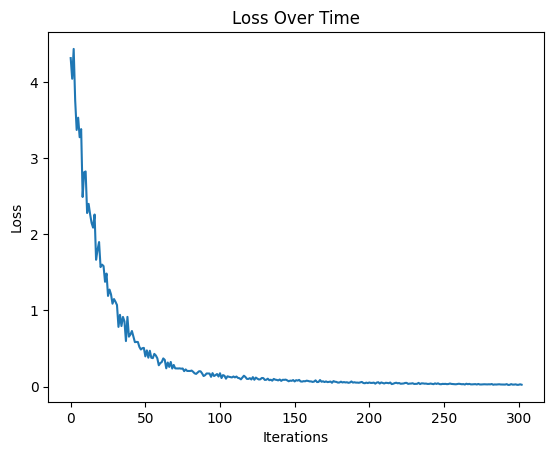

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Print the shape of the loss history array
print("number of steps with loss recorded:", np.shape(loss_history)[0])

# Plot the loss history to visualize how the loss changes over time
plt.plot(loss_history)
plt.xlabel('Iterations')  # X-axis label indicating the number of iterations (batches)
plt.ylabel('Loss')        # Y-axis label indicating the loss value
plt.title('Loss Over Time')  # Title of the plot
plt.show()  # Display the plot


In [7]:
# ----------------------------------------------------------------------------
# Testen des Modells
# ----------------------------------------------------------------------------
from IPython.display import HTML, display

# Function to display colored text
def color_text(text, color):
    display(HTML(f"<span style='color:{color}'>{text}</span>"))

model.eval()
for words in sentences:
  test_sentence = words
  test_tokens  = tokenize_sentence(test_sentence, vocab)
  mylen = len(test_tokens)
  print(mylen)
  test_input = torch.tensor(pad_sequence(test_tokens[:-1], max_len))
  test_input = test_input.unsqueeze(0)  # Add batch dimension
  output = model(test_input)
  predicted_ids = torch.argmax(output[:mylen], dim=-1)
  #print("predicted_ids: ", predicted_ids[:,:mylen])
  predicted_ids2 = predicted_ids[:,:mylen]
  decoded_input = [vocab[id.item()] for id in test_input.squeeze()]
  decoded_output = [vocab[id.item()] for id in predicted_ids2.squeeze()]
  print("test_sentence: \t \t \t \t \t", test_sentence)
  print("test input   :", test_input, ": ", " ".join(decoded_input))
  print("test_output  :", predicted_ids, ":", " ".join(decoded_output))
  success = (" ".join(decoded_output) == test_sentence)
  result = "Result: " + str(success)
  color_text(result,"green")

3
test_sentence: 	 	 	 	 	 I am hungry
test input   : tensor([[1, 2, 0, 0, 0, 0]]) :  I am    
test_output  : tensor([[ 1,  2, 43, 43, 43, 43]]) : I am hungry


3
test_sentence: 	 	 	 	 	 you are tired
test input   : tensor([[3, 6, 0, 0, 0, 0]]) :  you are    
test_output  : tensor([[ 3,  6, 44, 44, 44, 44]]) : you are tired


3
test_sentence: 	 	 	 	 	 we are happy
test input   : tensor([[5, 6, 0, 0, 0, 0]]) :  we are    
test_output  : tensor([[ 5,  6, 45, 45, 45, 45]]) : we are happy


3
test_sentence: 	 	 	 	 	 they are sad
test input   : tensor([[54,  6,  0,  0,  0,  0]]) :  they are    
test_output  : tensor([[54,  6, 46, 46, 46, 46]]) : they are sad


3
test_sentence: 	 	 	 	 	 it is simple
test input   : tensor([[47,  4,  0,  0,  0,  0]]) :  it is    
test_output  : tensor([[47,  4, 10, 10, 10, 10]]) : it is simple


4
test_sentence: 	 	 	 	 	 the weather is nice
test input   : tensor([[ 9, 34,  4,  0,  0,  0]]) :  the weather is   
test_output  : tensor([[ 9, 34,  4, 35, 35, 35]]) : the weather is nice


3
test_sentence: 	 	 	 	 	 this is bad
test input   : tensor([[49,  4,  0,  0,  0,  0]]) :  this is    
test_output  : tensor([[49,  4, 50, 50, 50, 50]]) : this is bad


3
test_sentence: 	 	 	 	 	 this was good
test input   : tensor([[49, 55,  0,  0,  0,  0]]) :  this was    
test_output  : tensor([[49, 55, 48, 48, 48, 48]]) : this was good


4
test_sentence: 	 	 	 	 	 we want to eat
test input   : tensor([[ 5, 25, 29,  0,  0,  0]]) :  we want to   
test_output  : tensor([[ 5, 25, 29, 51, 51, 51]]) : we want to eat


4
test_sentence: 	 	 	 	 	 they want to drink
test input   : tensor([[54, 25, 29,  0,  0,  0]]) :  they want to   
test_output  : tensor([[54, 25, 29, 52, 52, 52]]) : they want to drink


3
test_sentence: 	 	 	 	 	 you can come
test input   : tensor([[ 3, 22,  0,  0,  0,  0]]) :  you can    
test_output  : tensor([[ 3, 22, 53, 53, 53, 53]]) : you can come


3
test_sentence: 	 	 	 	 	 we go home
test input   : tensor([[ 5, 42,  0,  0,  0,  0]]) :  we go    
test_output  : tensor([[ 5, 42, 30, 30, 30, 30]]) : we go home


5
test_sentence: 	 	 	 	 	 they play in the garden
test input   : tensor([[54, 31, 32,  9,  0,  0]]) :  they play in the  
test_output  : tensor([[54, 31, 32,  9, 33, 33]]) : they play in the garden


4
test_sentence: 	 	 	 	 	 the weather is nice
test input   : tensor([[ 9, 34,  4,  0,  0,  0]]) :  the weather is   
test_output  : tensor([[ 9, 34,  4, 35, 35, 35]]) : the weather is nice


4
test_sentence: 	 	 	 	 	 he drives to Berlin
test input   : tensor([[41, 36, 29,  0,  0,  0]]) :  he drives to   
test_output  : tensor([[41, 36, 29, 37, 37, 37]]) : he drives to Berlin


4
test_sentence: 	 	 	 	 	 she reads a book
test input   : tensor([[40, 38,  7,  0,  0,  0]]) :  she reads a   
test_output  : tensor([[40, 38,  7, 39, 39, 39]]) : she reads a book


In [8]:
# Create the dataset
dataset = SimpleDataset(sentences, vocab, max_len)
print(sentences)
for entry in dataset:
    print(entry)
print("-------------------------------------------")
# Iterate over the dataset and print the data entries
for i in range(len(dataset)):
    x, y = dataset[i]
    print("x=",x)
    print("y=",y)

    # Decode x
    decoded_x = [vocab[token.item()] for token in x]
    print(f"Data entry {i}:")
    print(f"x = {' '.join(decoded_x)}")

    # Decode y
    decoded_y = [vocab[token.item()] for token in y]
    print(f"y = {' '.join(decoded_y)}")
    print("   ", sentences[i])
    print()

['I am hungry', 'you are tired', 'we are happy', 'they are sad', 'it is simple', 'the weather is nice', 'this is bad', 'this was good', 'we want to eat', 'they want to drink', 'you can come', 'we go home', 'they play in the garden', 'the weather is nice', 'he drives to Berlin', 'she reads a book']
(tensor([1, 2, 0, 0, 0, 0]), tensor([ 1,  2, 43,  0,  0,  0]))
(tensor([3, 6, 0, 0, 0, 0]), tensor([ 3,  6, 44,  0,  0,  0]))
(tensor([5, 6, 0, 0, 0, 0]), tensor([ 5,  6, 45,  0,  0,  0]))
(tensor([54,  6,  0,  0,  0,  0]), tensor([54,  6, 46,  0,  0,  0]))
(tensor([47,  4,  0,  0,  0,  0]), tensor([47,  4, 10,  0,  0,  0]))
(tensor([ 9, 34,  4,  0,  0,  0]), tensor([ 9, 34,  4, 35,  0,  0]))
(tensor([49,  4,  0,  0,  0,  0]), tensor([49,  4, 50,  0,  0,  0]))
(tensor([49, 55,  0,  0,  0,  0]), tensor([49, 55, 48,  0,  0,  0]))
(tensor([ 5, 25, 29,  0,  0,  0]), tensor([ 5, 25, 29, 51,  0,  0]))
(tensor([54, 25, 29,  0,  0,  0]), tensor([54, 25, 29, 52,  0,  0]))
(tensor([ 3, 22,  0,  0,  0, 

In [9]:
n = 0
for x, y in dataloader:
    print(n, ") x=")
    for seq in x:  # Iterate over each sequence in the batch
        decoded_x = [vocab[token.item()] for token in seq.squeeze()]  # Decode the sequence
        print("\t", " ".join(decoded_x))  # Join decoded words into a single string

    print("    y=")
    for seq in y:  # Iterate over each target sequence in the batch
        decoded_y = [vocab[token.item()] for token in seq.squeeze()]  # Decode the sequence
        print("\t", " ".join(decoded_y))  # Join decoded words into a single string

    n += 1

0 ) x=
	 it is    
	 they play in the  
	 they want to   
	 the weather is   
	 I am    
	 the weather is   
    y=
	 it is simple   
	 they play in the garden 
	 they want to drink  
	 the weather is nice  
	 I am hungry   
	 the weather is nice  
1 ) x=
	 he drives to   
	 this is    
	 you are    
	 we want to   
	 we are    
	 we go    
    y=
	 he drives to Berlin  
	 this is bad   
	 you are tired   
	 we want to eat  
	 we are happy   
	 we go home   
2 ) x=
	 this was    
	 you can    
	 they are    
	 she reads a   
    y=
	 this was good   
	 you can come   
	 they are sad   
	 she reads a book  


In [10]:
# ------------------------------------------------------------------------------
# Testing tokenization, padding, and decoding
# ------------------------------------------------------------------------------

# Print vocabulary with indices
print("Vocabulary:")
for jj in range(1, len(vocab)):  # Assuming vocab starts from 1
    print(f"{jj}: {vocab[jj]}", end=" ")
    if jj % 20 == 0:
        print()
print("\n")

# Tokenize and pad all sentences
max_len = 6
mydata = [pad_sequence(tokenize_sentence(sentence, vocab), max_len=max_len) for sentence in sentences]

# Test tokenization, padding, and decoding for each sentence
print("Testing tokenization, padding, and decoding:")
for sentence in sentences:
    print(f"Original Sentence: {sentence}")

    # Tokenization
    tokenized = tokenize_sentence(sentence, vocab)
    print(f"Tokenized: {tokenized}")

    # Padding
    padded = pad_sequence(tokenized, max_len=max_len)
    print(f"Padded: {padded}")

    # Decoding
    decoded = [vocab[id] for id in padded]
    print(f"Decoded: {' '.join(decoded)}")
    print("---")

# Iterate over tokenized and padded sequences
print("Final Data:")
for i, seq in enumerate(mydata):
    seq_word = [vocab[jj] for jj in seq]  # Decode the sequence
    print(f"Sequence {i+1} \t: {seq}")
    print(f"\tDecoded : {' '.join(seq_word)}")
    print(f"\tOriginal: {sentences[i]}")


Vocabulary:
1: I 2: am 3: you 4: is 5: we 6: are 7: a 8: an 9: the 10: simple 11: example 12: with 13: and 14: but 15: or 16: not 17: only 18: also 19: how 20: what 
21: why 22: can 23: must 24: should 25: want 26: has 27: have 28: had 29: to 30: home 31: play 32: in 33: garden 34: weather 35: nice 36: drives 37: Berlin 38: reads 39: book 40: she 
41: he 42: go 43: hungry 44: tired 45: happy 46: sad 47: it 48: good 49: this 50: bad 51: eat 52: drink 53: come 54: they 55: was 

Testing tokenization, padding, and decoding:
Original Sentence: I am hungry
Tokenized: [1, 2, 43]
Padded: [1, 2, 43, 0, 0, 0]
Decoded: I am hungry   
---
Original Sentence: you are tired
Tokenized: [3, 6, 44]
Padded: [3, 6, 44, 0, 0, 0]
Decoded: you are tired   
---
Original Sentence: we are happy
Tokenized: [5, 6, 45]
Padded: [5, 6, 45, 0, 0, 0]
Decoded: we are happy   
---
Original Sentence: they are sad
Tokenized: [54, 6, 46]
Padded: [54, 6, 46, 0, 0, 0]
Decoded: they are sad   
---
Original Sentence: it is si

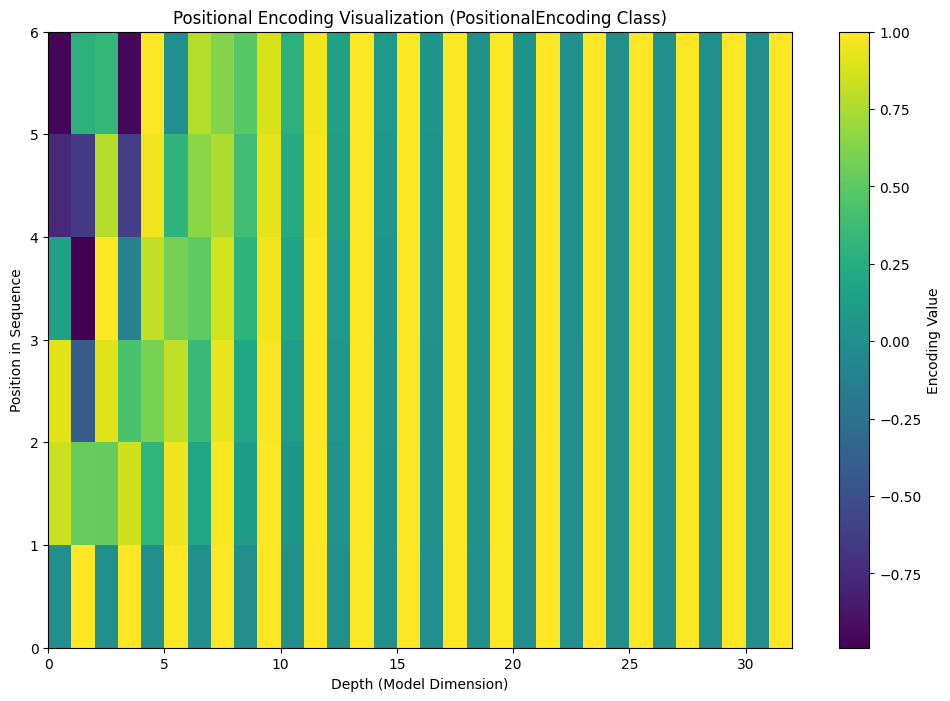

In [11]:
# Initialize PositionalEncoding
pos_encoding_layer = PositionalEncoding(d_model, max_len)

# Extract the positional encodings
pos_encoding = pos_encoding_layer.pe.squeeze(1).numpy()

# Plot the positional encoding
plt.figure(figsize=(12, 8))
plt.pcolormesh(pos_encoding, cmap='viridis')
plt.xlabel('Depth (Model Dimension)')
plt.xlim((0, d_model))
plt.ylabel('Position in Sequence')
plt.ylim((0, max_len))
plt.colorbar(label="Encoding Value")
plt.title('Positional Encoding Visualization (PositionalEncoding Class)')
plt.show()
